<img src="slides/8_22.png">

In [1]:
import pandas as pd
import seaborn as sns
iris = sns.load_dataset('iris')

# species が setosa のデータを除去
df = iris.query('species!="setosa"')

# データセットの確認
df.iloc[[0, 50]]

,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
100,6.3,3.3,6.0,2.5,virginica


## 決定木による species の分類

- sepal_length, sepal_width, petal_length, petal_width を説明変数として species を分類する決定木を作成
- 目的変数はダミー変数化されていないことに注意

In [2]:
# 説明変数、目的変数の作成
X = df.drop(['species'], axis=1)
Y = df.species

# 決定木を作成、正確度を表示
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X, Y)
model.score(X, Y)

1.0

## 決定木の描画

 ```plot_tree()``` を使用すると Jupyter Notebook 中に描画できる
 
- ```plt.figure(figsize=(12, 10))``` 図の大きさを調整
- ```feature_names=X.columns``` 説明変数名の設定
- ```class_names=model.classes_``` 分類クラス名の設定
- ```filled=True``` ノードの色分け

```plot_tree()``` で描画する場合、True, False は表示されない
- 左が True, 右が False となるのが一般的

決定木が大きくなると ```plot_tree()``` での描画はうまくいかない（止まらなくなる）場合がある
- いつまでたっても描画されない場合は、メニューの Kernel > Interrupt で停止させる
- Graphviz ```export_graphviz()``` を試す

最後に ```plt.show()``` を入れてあるのは ```plot_tree()``` の戻り値（決定木の内容）の表示を抑制するため

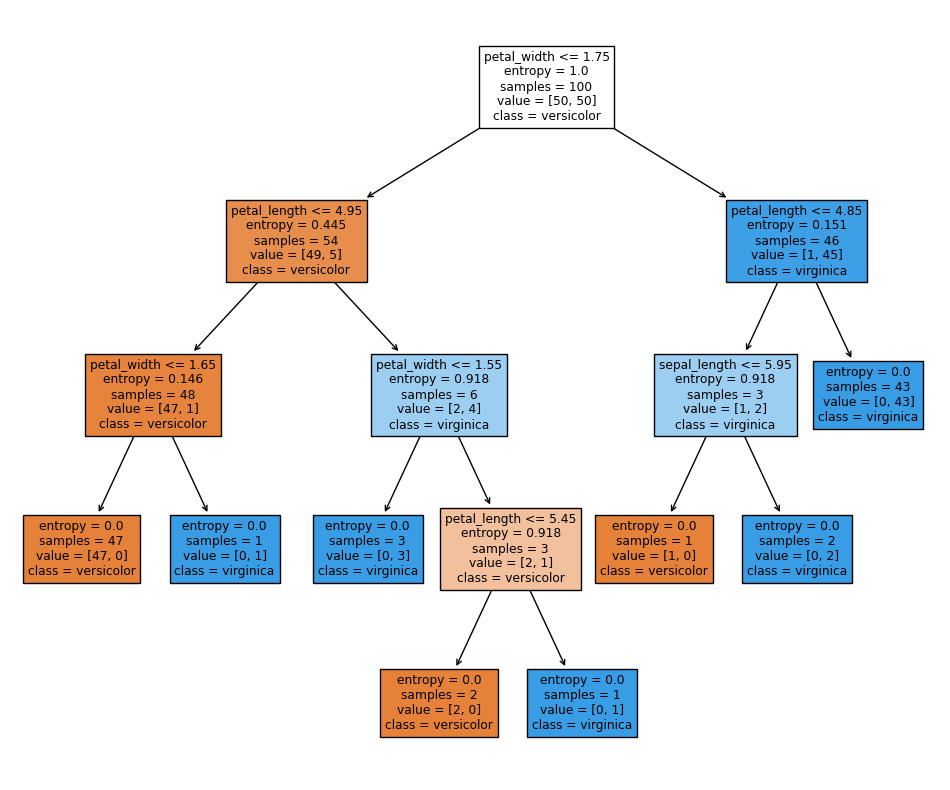

In [3]:
# 作成した決定木の描画
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# 描画領域の設定（大きくする）
plt.figure(figsize=(12, 10))
# 決定木
plot_tree(model, feature_names=X.columns, class_names=model.classes_, filled=True)
plt.show()

## 情報利得の総和

情報利得の総和は ```feature_importances_``` から取得できる
- この総和は正規化 (0~1) されていることに注意

In [4]:
model.feature_importances_

array([0.02754888, 0.        , 0.18461664, 0.78783449])

In [6]:
sum(model.feature_importances_)

1.0

### 情報利得の総和：表形式で表示（縦）

- pandas DataFrame に変換、表示
- 4行1列の形式になる

In [7]:
pd.DataFrame(model.feature_importances_, index=X.columns, columns=['gain'])

,gain
sepal_length,0.027549
sepal_width,0.000000
petal_length,0.184617
petal_width,0.787834


### 情報利得の総和：表形式で表示（横）

- ```reshape()``` で1行4列に変換してから DataFrame に変換、表示

In [8]:
pd.DataFrame(model.feature_importances_.reshape(1, 4), columns=X.columns, index=['gain'])

,sepal_length,sepal_width,petal_length,petal_width
gain,0.027549,0.0,0.184617,0.787834


## 散布図

分割条件を重ねて表示
- petal_width <= 1.65, petal_length <= 4.95 ... versicolor 47
- petal_width > 1.75, petal_length > 4.85 ... virginica 43

種の色が決定木と逆なことに注意

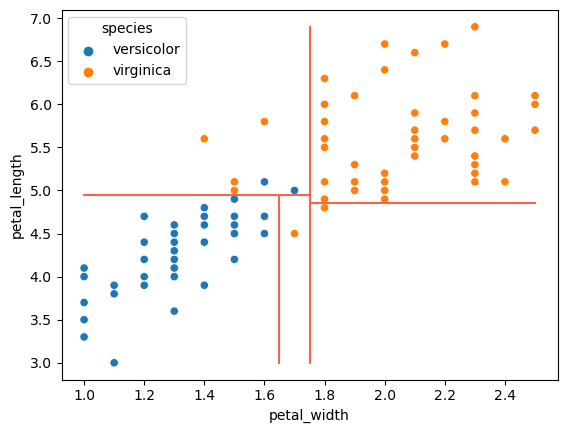

In [9]:
sns.scatterplot(x=df.petal_width, y=df.petal_length, hue=df.species)

petal_length_min = df.petal_length.min()
petal_length_max = df.petal_length.max()
petal_width_min = df.petal_width.min()
petal_width_max = df.petal_width.max()

# １．根ノード：petal_width <= 1.75
x = 1.75
plt.plot([x, x], [petal_length_min, petal_length_max], color='tomato')

# ２．１の左下：petal_length <= 4.95
y = 4.95
plt.plot([petal_width_min, x], [y, y], color='tomato')

# ３．２の左下：petal_width <= 1.65
x = 1.65
plt.plot([x, x], [petal_length_min, y], color='tomato')

# ４．１の右下：petal_length > 4.85
x = 1.75
y = 4.85
plt.plot([x, petal_width_max], [y, y], color='tomato')

大多数（約9割）が右上と左下の領域に入る。
- virginica, versicolor という対象を見たい時には、右上と左下の領域の条件で絞り込むと、大部分が入る。

右下の領域は virginica だけに見えるが、決定木を見ると、両方の種があり、重なって表示されていることがわかる。
- 右下：petal_length <= 4.85 value=[1, 2]

### 精度の計算・表示

In [10]:
# 正確度、適合度、再現率（感度）、AUCの算出
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
Y_predict = model.predict(X)
Y_proba = model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
print('正確度={:.3f}, 適合度={:.3f}, 再現率={:.3f}, AUC={:.3f}'.format(
    accuracy_score(Y, Y_predict), precision_score(Y, Y_predict),
    recall_score(Y, Y_predict), auc(fpr, tpr)))
# エラーが出る

ValueError: y_true takes value in {'versicolor', 'virginica'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

roc_curve で、ダミー変数化するか、pos_label で正例ラベルを指定するように、エラーがでる。<br>
precision_score (適合度), recall_score (感度) でも pos_label が必要。

In [11]:
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1], pos_label='virginica')
print('正確度={:.3f}, 適合度={:.3f}, 再現率={:.3f}, AUC={:.3f}'.format(
    accuracy_score(Y, Y_predict),
    precision_score(Y, Y_predict, pos_label='virginica'),
    recall_score(Y, Y_predict, pos_label='virginica'),
    auc(fpr, tpr)))

正確度=1.000, 適合度=1.000, 再現率=1.000, AUC=1.000


<img src='slides/6_27.png'>